Questo file nasce dall'idea avuta dal Vittorio di analizzare la performance di un modello semplice come tf-idf in un setting supervised (labels create da lui per il dominio medico con chatgpt) per vedere se almeno in questo setting ci sono dei buoni risultati.

File creato il 20 Aprile

# TF-IDF

In [4]:
import pickle
with open('FilePickles\corpusParoleInutiliStemming_layer1.pkl', 'rb') as file:
    #Carica i dati dal file
    corpus_filtrato1 = pickle.load(file)
#len(corpus_filtrato[0])

In [10]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = corpus_filtrato1

corpus_str = [" ".join(document) for document in corpus]

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus_str)
feature_names = vectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
print(df_tfidf.head())

         10       100  1007  101  102  103  105  108   11  110  ...   wt   xy  \
0  0.000000  0.000000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1  0.000000  0.000000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2  0.000000  0.000000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3  0.033327  0.094982   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4  0.067666  0.000000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

   zamipril  zecc  zoledron       zon  zooepidemicus  zoonos  zopp  zupp  
0       0.0   0.0       0.0  0.000000            0.0     0.0   0.0   0.0  
1       0.0   0.0       0.0  0.063827            0.0     0.0   0.0   0.0  
2       0.0   0.0       0.0  0.000000            0.0     0.0   0.0   0.0  
3       0.0   0.0       0.0  0.000000            0.0     0.0   0.0   0.0  
4       0.0   0.0       0.0  0.000000            0.0     0.0   0.0   0.0  

[5 rows x 3850 columns]


In [15]:
print(df_tfidf.shape)

(86, 3850)


In [16]:
df_E3C = pd.read_excel('df_E3C.xlsx')

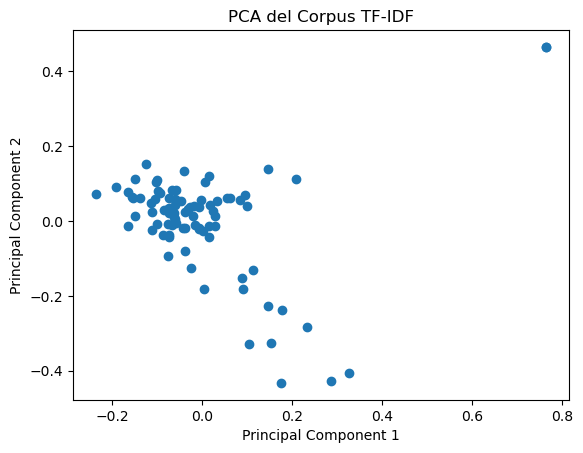

Percentuale di varianza spiegata dalle prime due componenti: 4.88%


In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

n_components = 2  # Decidi quanti componenti vuoi estrarre
pca = PCA(n_components=n_components)

# Fit PCA sul TF-IDF matrix
pca_result = pca.fit_transform(tfidf_matrix.toarray())

# Crea un DataFrame con i risultati di PCA
df_pca = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(n_components)])

# Visualizzazione delle prime due componenti principali
plt.scatter(df_pca["PC1"], df_pca["PC2"])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA del Corpus TF-IDF")
plt.show()

# Calcola la percentuale di varianza spiegata dalle prime due componenti
explained_variance = pca.explained_variance_ratio_
variance_explained_by_two = sum(explained_variance) * 100  # Converti in percentuale

print(f"Percentuale di varianza spiegata dalle prime due componenti: {variance_explained_by_two:.2f}%")

Il grosso problema è che le prime due pc spiegano solo il 4,88% della variabilità, quindi dovremmo prendere almeno 100 pc per poter ottenere qualcosa, ma avendo pochi dati su layer 1 (86) avremmo un numero di features maggiore del numero di dati. Questo ci condurrebbe a un modello non buono!

# Doc2Vec
Proviamo a fare la stessa cosa con doc2vec, in tal maniera possiamo settare noi il numero di features (ovvero la dimensionalità dell'embedding)

In [21]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [22]:
tagged_test_corpus = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus_filtrato1)]
model = Doc2Vec(vector_size=3, min_count=2, epochs=40)
model.build_vocab(tagged_test_corpus)

# Addestra il modello
model.train(tagged_test_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [23]:
vector = model.infer_vector(['bambin', 'sette', 'anni', 'è','stat', 'ricoverat', 'bronchite'])
print(vector)

[-0.6377564   0.22566025  0.00170678]


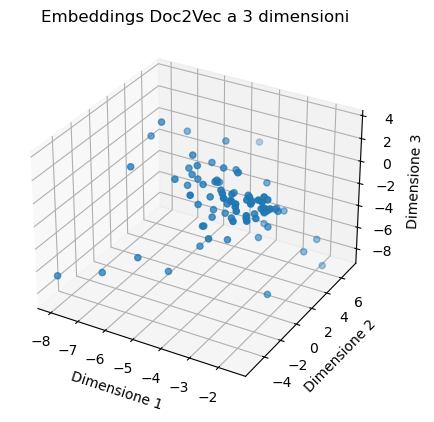

In [24]:
embeddings = [model.dv[i] for i in range(len(tagged_test_corpus))]

# Crea un plot 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Estrai le coordinate x, y, z dai tuoi embeddings
x_coords = [embedding[0] for embedding in embeddings]
y_coords = [embedding[1] for embedding in embeddings]
z_coords = [embedding[2] for embedding in embeddings]

# Traccia i documenti nel grafico 3D
ax.scatter(x_coords, y_coords, z_coords)

# Aggiungi etichette agli assi
ax.set_xlabel("Dimensione 1")
ax.set_ylabel("Dimensione 2")
ax.set_zlabel("Dimensione 3")

# Visualizza il grafico
plt.title("Embeddings Doc2Vec a 3 dimensioni")
plt.show()

In [25]:
!pip install plotly


In [35]:
import plotly.express as px

embeddings = [model.dv[i] for i in range(len(tagged_test_corpus))]

# Estrai le coordinate x, y, z dai tuoi embeddings
x_coords = [embedding[0] for embedding in embeddings]
y_coords = [embedding[1] for embedding in embeddings]
z_coords = [embedding[2] for embedding in embeddings]

# Crea un DataFrame con le coordinate
df = pd.DataFrame({
    "x": x_coords,
    "y": y_coords,
    "z": z_coords,
    "Documento": [f"Doc {i}" for i in range(len(x_coords))],  # Etichette per i documenti
})

dimensione_punti = 3  # Diminuire per avere punti più piccoli

# Crea un grafico 3D con Plotly e riduci la dimensione del testo
fig = px.scatter_3d(
    df, x='x', y='y', z='z', text='Documento', title="Embeddings Doc2Vec a 3 dimensioni",
    size=[dimensione_punti] * len(x_coords),  # Dimensione uniforme
    size_max=5,  # Dimensione massima dei punti
    opacity=0.7  # Controlla la trasparenza dei punti
)

# Riduci la dimensione del testo
fig.update_traces(textfont=dict(size=8))  # Riduci la dimensione delle etichette di testo

# Regola i limiti degli assi per evitare compressione
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X', range=[min(x_coords), max(x_coords)]),
        yaxis=dict(title='Y', range=[min(y_coords), max(y_coords)]),
        zaxis=dict(title='Z', range=[min(z_coords), max(z_coords)]),
    )
)

# Mostra il grafico interattivo
fig.show()

Proviamo ora a fittare un modello di classificazione di doc2vec!

In [41]:
embeddings

[array([-6.8122516, -4.0168076, -6.3381686], dtype=float32),
 array([-5.087824 , -1.8568385, -6.39959  ], dtype=float32),
 array([-3.2681034,  3.6644297, -3.4451447], dtype=float32),
 array([-5.1997676,  0.8105659, -0.5226108], dtype=float32),
 array([-4.7291107,  1.1009164, -0.2983972], dtype=float32),
 array([-2.4933255,  0.7049951, -0.5739644], dtype=float32),
 array([-3.0773997 ,  1.0471344 , -0.21617569], dtype=float32),
 array([-8.015034 , -5.3616085, -6.631443 ], dtype=float32),
 array([-1.7737176,  5.117809 , -5.709857 ], dtype=float32),
 array([-1.9934502,  4.2407756, -6.4214563], dtype=float32),
 array([-2.4043815,  1.0949188, -8.478616 ], dtype=float32),
 array([-4.051317  ,  2.9924703 ,  0.02855911], dtype=float32),
 array([-3.9753256,  1.2216841, -2.394981 ], dtype=float32),
 array([-4.193719  ,  0.38573876, -2.3592653 ], dtype=float32),
 array([-4.185714 ,  3.5628204, -0.3900982], dtype=float32),
 array([-4.4365587,  1.8156661, -0.3583019], dtype=float32),
 array([-2.5569

In [42]:
df = pd.DataFrame(embeddings, columns=["x", "y", "z"])

# Mostra il DataFrame
print(df)

           x         y         z
0  -6.812252 -4.016808 -6.338169
1  -5.087824 -1.856838 -6.399590
2  -3.268103  3.664430 -3.445145
3  -5.199768  0.810566 -0.522611
4  -4.729111  1.100916 -0.298397
..       ...       ...       ...
81 -2.725717  0.921716 -0.153848
82 -2.636863  1.055955 -0.351742
83 -5.320115  1.376198  0.559782
84 -6.787470 -0.677496  0.933428
85 -6.063871  3.649852  1.959313

[86 rows x 3 columns]


In [45]:
df_E3C.columns

Index(['Unnamed: 0', 'id', 'text', 'age', 'symptoms', 'gender', 'domain',
       'diagnosis', 'outcome', 'Orthopedics', 'Cardiology', 'Neurology',
       'Endocrinology', 'Pulmonology', 'Nephrology', 'Oncology',
       'Gastroenterology', 'Hematology', 'Infectious Diseases', 'Rheumatology',
       'Psychiatry', 'Internal Medicine', 'Geriatrics', 'Urology',
       'Toxicology', 'Genetics', 'Pediatrics', 'Outcome_2', 'last_sentences'],
      dtype='object')

In [49]:
df_E3C_Y_contrastive = df_E3C.loc[:,['Orthopedics', 'Cardiology', 'Neurology',
       'Endocrinology', 'Pulmonology', 'Nephrology', 'Oncology',
       'Gastroenterology', 'Hematology', 'Infectious Diseases', 'Rheumatology',
       'Psychiatry', 'Internal Medicine', 'Geriatrics', 'Urology',
       'Toxicology', 'Genetics', 'Pediatrics']]

In [50]:
df_E3C_Y_contrastive

,Orthopedics,Cardiology,Neurology,Endocrinology,Pulmonology,Nephrology,Oncology,Gastroenterology,Hematology,Infectious Diseases,Rheumatology,Psychiatry,Internal Medicine,Geriatrics,Urology,Toxicology,Genetics,Pediatrics
0,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
82,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
83,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
84,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False


In [51]:
df_E3C_Y_contrastive.sum()

Orthopedics             2
Cardiology             12
Neurology               8
Endocrinology           6
Pulmonology             4
Nephrology              4
Oncology               15
Gastroenterology       12
Hematology              9
Infectious Diseases     7
Rheumatology            1
Psychiatry              1
Internal Medicine       7
Geriatrics              1
Urology                 2
Toxicology              1
Genetics                1
Pediatrics             13
dtype: int64

considero solo i più frequenti ovvero peciatrics, cardiology, oncology, gastroenterology.

In [55]:
Y = []

# Oss questo codice mi permette di dare un'etichetta unica a ogni dato, secondo la regola che le etichette piu frequenti 
# hanno la priorità in caso di etichetta a valore multiplo!
for i in range(len(df_E3C_Y_contrastive)):
    if df_E3C_Y_contrastive.loc[i,'Oncology']==True:
        Y.append('Oncology')
    elif df_E3C_Y_contrastive.loc[i,'Pediatrics']==True:
        Y.append('Pediatrics')
    elif df_E3C_Y_contrastive.loc[i,'Cardiology']==True:
        Y.append('Cardiology')
    elif df_E3C_Y_contrastive.loc[i,'Gastroenterology']==True:
        Y.append('Gastroenterology')
    else:
        Y.append('Other')

In [59]:
Y

['Cardiology',
 'Other',
 'Other',
 'Other',
 'Oncology',
 'Gastroenterology',
 'Oncology',
 'Other',
 'Other',
 'Oncology',
 'Other',
 'Other',
 'Cardiology',
 'Cardiology',
 'Oncology',
 'Cardiology',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Cardiology',
 'Other',
 'Cardiology',
 'Other',
 'Gastroenterology',
 'Gastroenterology',
 'Gastroenterology',
 'Other',
 'Cardiology',
 'Other',
 'Cardiology',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Gastroenterology',
 'Gastroenterology',
 'Other',
 'Other',
 'Cardiology',
 'Cardiology',
 'Cardiology',
 'Other',
 'Oncology',
 'Gastroenterology',
 'Oncology',
 'Other',
 'Other',
 'Other',
 'Other',
 'Gastroenterology',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Pediatrics',
 'Pediatrics',
 'Pediatrics',
 'Pediatrics',
 'Pediatrics',
 'Pediatrics',
 'Oncology',
 'Other',
 'Oncology',
 'Other',
 'Oncology',
 'Oncology',
 'Oncology',
 'Pediatrics',
 'Pediatrics',
 'Oncology',
 'Pediatric

In [62]:
df['Y'] = Y

In [67]:
df

,x,y,z,Y
0,-6.812252,-4.016808,-6.338169,Cardiology
1,-5.087824,-1.856838,-6.399590,Other
2,-3.268103,3.664430,-3.445145,Other
3,-5.199768,0.810566,-0.522611,Other
4,-4.729111,1.100916,-0.298397,Oncology
...,...,...,...,...
81,-2.725717,0.921716,-0.153848,Other
82,-2.636863,1.055955,-0.351742,Other
83,-5.320115,1.376198,0.559782,Other
84,-6.787470,-0.677496,0.933428,Gastroenterology


In [71]:
conteggi = df["Y"].value_counts()
conteggi

Other               42
Oncology            15
Cardiology          11
Gastroenterology     9
Pediatrics           9
Name: Y, dtype: int64

In [72]:
df

,x,y,z,Y
0,-6.812252,-4.016808,-6.338169,Cardiology
1,-5.087824,-1.856838,-6.399590,Other
2,-3.268103,3.664430,-3.445145,Other
3,-5.199768,0.810566,-0.522611,Other
4,-4.729111,1.100916,-0.298397,Oncology
...,...,...,...,...
81,-2.725717,0.921716,-0.153848,Other
82,-2.636863,1.055955,-0.351742,Other
83,-5.320115,1.376198,0.559782,Other
84,-6.787470,-0.677496,0.933428,Gastroenterology


In [84]:
dimensione_punti = 1000  # Diminuire per avere punti più piccoli
fig = px.scatter_3d(
    df,
    x='x',
    y='y',
    z='z',
    color='Y',  # Colora i punti in base alla colonna 'Y'
    title="Grafico 3D con colori basati sull'etichetta 'Y'",
    labels={'x': 'Asse X', 'y': 'Asse Y', 'z': 'Asse Z'},
    size=[dimensione_punti] * len(x_coords),  # Dimensione uniforme
    size_max=10,  # Dimensione massima dei punti
    opacity=0.7  # Controlla la trasparenza dei punti
)

# Riduci la dimensione del testo
fig.update_traces(textfont=dict(size=8))  # Riduci la dimensione delle etichette di testo

# Regola i limiti degli assi per evitare compressione
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X', range=[min(x_coords), max(x_coords)]),
        yaxis=dict(title='Y', range=[min(y_coords), max(y_coords)]),
        zaxis=dict(title='Z', range=[min(z_coords), max(z_coords)]),
    )
)

# Mostra il grafico interattivo
fig.show()


In [87]:
dimensione_punti = 3  # Diminuire per avere punti più piccoli
fig = px.scatter_3d(
    df,
    x='x',
    y='y',
    z='z',
    text='Y',
    color='Y',  # Colora i punti in base alla colonna 'Y'
    title="Grafico 3D con colori basati sull'etichetta 'Y'",
    labels={'x': 'Asse X', 'y': 'Asse Y', 'z': 'Asse Z'},
    size=[dimensione_punti] * len(x_coords),  # Dimensione uniforme
    size_max=10,  # Dimensione massima dei punti
    opacity=0.7  # Controlla la trasparenza dei punti
)

# Riduci la dimensione del testo
fig.update_traces(textfont=dict(size=5))  # Riduci la dimensione delle etichette di testo

# Regola i limiti degli assi per evitare compressione
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X', range=[min(x_coords), max(x_coords)]),
        yaxis=dict(title='Y', range=[min(y_coords), max(y_coords)]),
        zaxis=dict(title='Z', range=[min(z_coords), max(z_coords)]),
    )
)

# Mostra il grafico interattivo
fig.show()


Proviamo a trainare un modello supervised!

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Separiamo le caratteristiche (X) e le etichette (y)
X = df[['x', 'y', 'z']]  # Caratteristiche
y = df['Y']  # Etichette

# Usa LabelEncoder per codificare le etichette come numeri
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Dividiamo i dati in set di allenamento e test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Crea il modello MLP con un solo strato nascosto e qualche configurazione di base
mlp = MLPClassifier(hidden_layer_sizes=(10,), max_iter=500, activation='relu', solver='adam', random_state=42)

# Addestra il modello con il set di allenamento
mlp.fit(X_train, y_train)

# Fai previsioni con il set di test
y_pred = mlp.predict(X_test)

# Valuta l'accuratezza del modello
accuracy = accuracy_score(y_test, y_pred)

print("Accuratezza:", accuracy)

# Stampa il rapporto di classificazione per maggiori dettagli
print("Rapporto di classificazione:")
print(classification_report(y_test, y_pred))

Accuratezza: 0.34615384615384615
Rapporto di classificazione:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         6
           3       0.38      1.00      0.55         9
           4       0.00      0.00      0.00         6

    accuracy                           0.35        26
   macro avg       0.07      0.20      0.11        26
weighted avg       0.13      0.35      0.19        26



C:\Users\enduser\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

C:\Users\enduser\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\enduser\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\enduser\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [90]:
y_pred

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3,
       3, 2, 3, 3])